In [1]:
!pip install opencv-python tensorflow

In [2]:

import numpy as np 
import pandas as pd 
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import os
from tensorflow.keras.preprocessing.image import load_img,img_to_array


In [4]:
normal_dir = r'C:\Users\Naman\Desktop\research work\models\lungs\chest_xray\chest_xray\train\NORMAL'
normal_img = [f for f in os.listdir(normal_dir) if os.path.isfile(os.path.join(normal_dir, f))]
normal_img[:10]

['IM-0115-0001.jpeg',
 'IM-0117-0001.jpeg',
 'IM-0119-0001.jpeg',
 'IM-0122-0001.jpeg',
 'IM-0125-0001.jpeg',
 'IM-0127-0001.jpeg',
 'IM-0128-0001.jpeg',
 'IM-0129-0001.jpeg',
 'IM-0131-0001.jpeg',
 'IM-0133-0001.jpeg']

In [5]:
print(len(normal_img))

1341


In [6]:
pneumonia_dir = r'C:\Users\Naman\Desktop\research work\models\lungs\chest_xray\chest_xray\train\PNEUMONIA'
pneumonia_img = [f for f in os.listdir(pneumonia_dir) if os.path.isfile(os.path.join(pneumonia_dir, f))]
pneumonia_img = pneumonia_img[:1341]
pneumonia_img[:10]

['person1000_bacteria_2931.jpeg',
 'person1000_virus_1681.jpeg',
 'person1001_bacteria_2932.jpeg',
 'person1002_bacteria_2933.jpeg',
 'person1003_bacteria_2934.jpeg',
 'person1003_virus_1685.jpeg',
 'person1004_bacteria_2935.jpeg',
 'person1004_virus_1686.jpeg',
 'person1005_bacteria_2936.jpeg',
 'person1005_virus_1688.jpeg']

In [7]:
print(len(pneumonia_img))

1341


In [8]:
import os
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir1 = r'C:\Users\Naman\Desktop\research work\models\lungs\chest_xray\chest_xray\train\PNEUMONIA'
dataset_dir2 = r'C:\Users\Naman\Desktop\research work\models\lungs\chest_xray\chest_xray\train\NORMAL'
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        if label == 1:
            image_path = os.path.join(dataset_dir1, img)
        else:
            image_path = os.path.join(dataset_dir2, img)

        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [9]:
dataset = create_dataset(pneumonia_img,1)

100%|██████████| 1341/1341 [00:18<00:00, 72.02it/s]


In [10]:
len(dataset)

1341

In [11]:
dataset = create_dataset(normal_img,0)

100%|██████████| 1341/1341 [00:33<00:00, 39.55it/s]


In [12]:
len(dataset)

2682

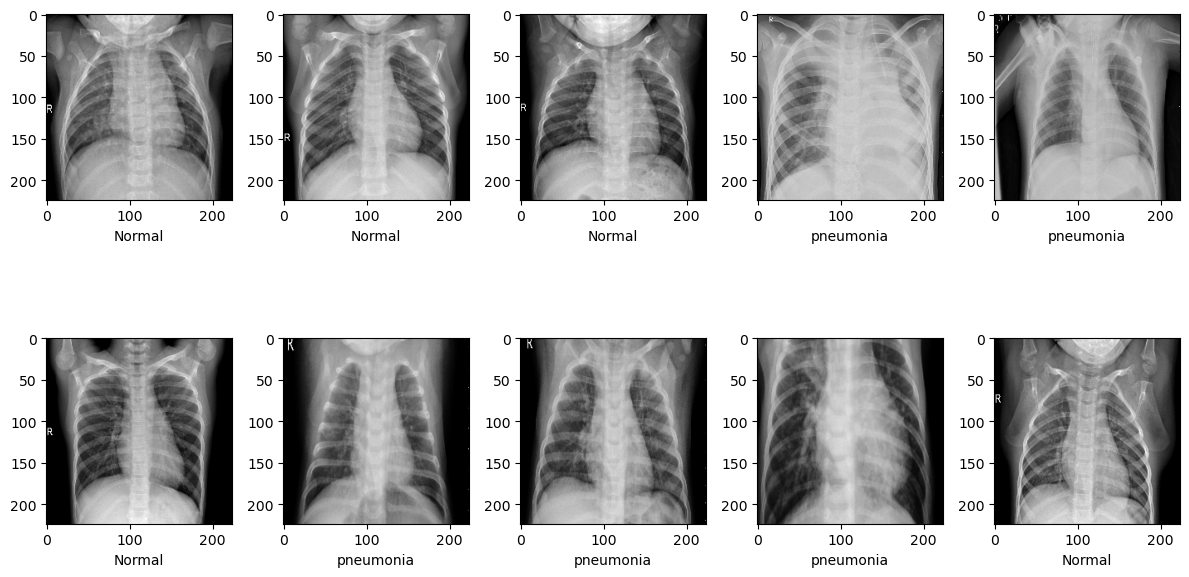

In [13]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "pneumonia"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()  

In [14]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])
x=x/255

In [15]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,stratify=y)

In [16]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

In [17]:
for layer in vgg.layers:
    layer.trainable = False

In [18]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [19]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("vgg.keras", monitor="val_accuracy", verbose=1, save_best_only=True, save_weights_only=False, save_freq='epoch')
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, verbose=1)

In [23]:
history = model.fit(x_train,y_train,batch_size=32,epochs=10,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8051 - loss: 0.4080
Epoch 1: val_accuracy improved from -inf to 0.96648, saving model to vgg.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 575s 8s/step - accuracy: 0.8064 - loss: 0.4056 - val_accuracy: 0.9665 - val_loss: 0.1199
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9605 - loss: 0.1165
Epoch 2: val_accuracy improved from 0.96648 to 0.97207, saving model to vgg.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 537s 8s/step - accuracy: 0.9605 - loss: 0.1164 - val_accuracy: 0.9721 - val_loss: 0.0987
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9775 - loss: 0.0839
Epoch 3: val_accuracy improved from 0.97207 to 0.97952, saving model to vgg.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 523s 8s/step - accuracy: 0.9775 - loss: 0.0839 - val_accuracy: 0.9795 - val_loss: 0.0761
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9877 - loss: 0.0595
Epoch 4: val_accuracy did not improve from 0.97952
68/68 ━━━━━━━━━━━━━━━━━━━━

In [24]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

17/17 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - accuracy: 0.9809 - loss: 0.0526
loss: 0.06674003601074219
Accuracy: 0.9776536226272583


In [25]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)
print(classification_report(y_test,y_pred))

17/17 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       268
           1       1.00      0.96      0.98       269

    accuracy                           0.98       537
   macro avg       0.98      0.98      0.98       537
weighted avg       0.98      0.98      0.98       537



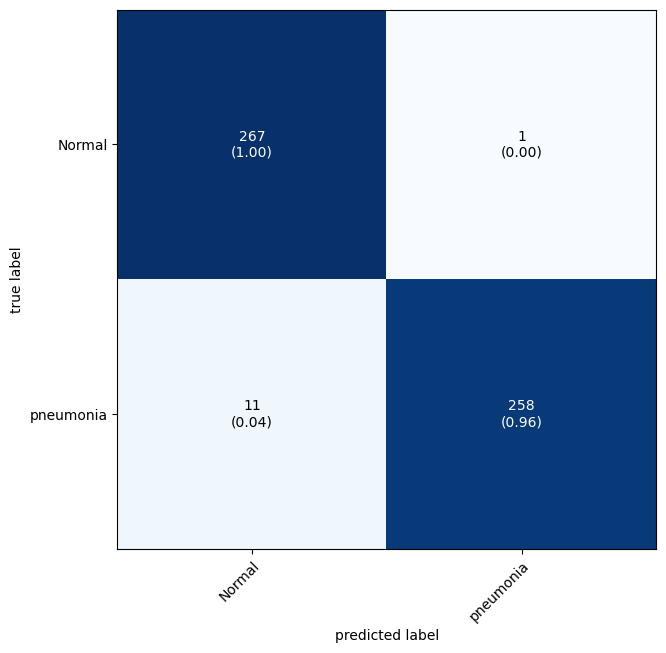

In [26]:
!pip install mlxtend
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["Normal","pneumonia"],
                      show_normed = True);

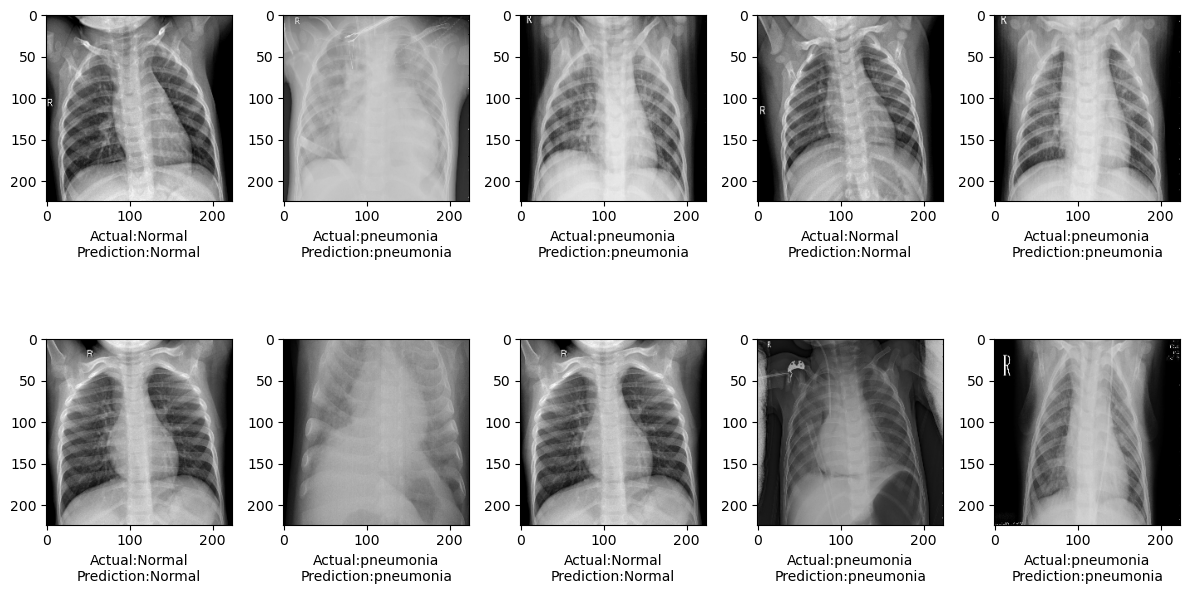

In [27]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "pneumonia"
        
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "pneumonia"
        
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout() 

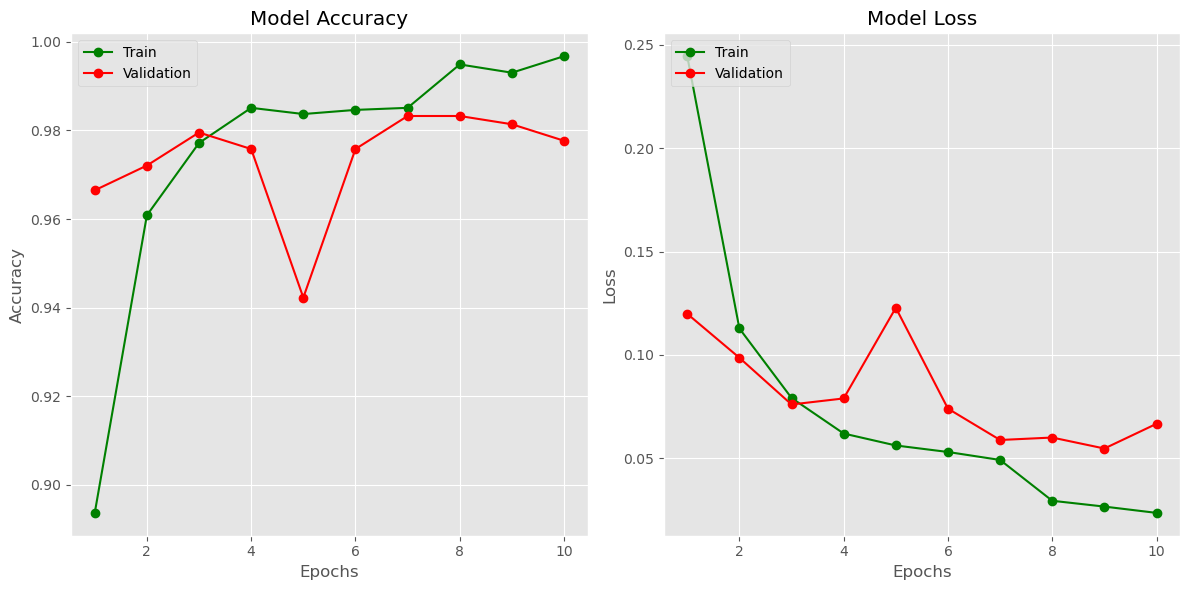

In [28]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12, 6))

epochs = range(1, len(history.history['accuracy']) + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], "go-", label="Train")
plt.plot(epochs, history.history["val_accuracy"], "ro-", label="Validation")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], "go-", label="Train")
plt.plot(epochs, history.history["val_loss"], "ro-", label="Validation")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()
